# Computational Cost Estimates for Cosmic Explorer

## Amber Lenon<sup>1</sup>, Alexander H. Nitz<sup>2,3</sup>, and Duncan A. Brown<sup>1</sup>

**<sup>1</sup> Department of Physics, Syracuse University, Syracuse NY 13224, USA**<br>
**<sup>2</sup> Max-Planck-Institut für Gravitationsphysik, Albert-Einstein-Institut, D-30167 Hannover, Germany**<br>
**<sup>3</sup> Leibniz Universität Hannover, D-30167 Hannover, Germany**

We compare the project computational cost estimates for Cosmic Explorer with those of Advanced LIGO. We find that since the low-frequency seismic wall of Cosmic Explorer is comparable to that of Advanced LIGO, the computational cost of searches for compact object binaries is of the same order of magnitude as that of Advnaced LIGO. Similarly, the cost of parameter estimation for a single event in Cosmic Explorer is comparable to Advanced LIGO and the cost of measuring the parameters of Cosmic Explorer event will not be substantially more expensive that for Advanced LIGO. The overall cost of Cosmic Explorer parameter estimation will scale with the number of events detected. Although the expected event rate will be three orders of magnitude larger than that of Advanced LIGO, the event rate will not be confusion limited. Techinques are available that can perform full parameter estimation of signals within one hour on current hardware resources and so we do not forsee significant computational challenges for Cosmic Explorer data analysis.

### Set up output plot format

In [1]:
import gc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.grid']=True
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

In [2]:
rcParams['figure.figsize']=(14,6)

### Set up data segment length for analysis

In [3]:
td_length = 2048 # seconds
srate = 4096 # Hz
f_low = 3.0 # Hz
N = int(td_length * srate)
fd_length = int(N / 2 + 1)
delta_t = 1.0 / srate
delta_f = 1.0 / td_length

### Read in and plot the power spectral density files for each detector

The strain noise curves are from [CE-T2000007-v2](https://dcc.cosmicexplorer.org/CE-T2000007-v2)

In [4]:
import pycbc.psd

psd_ce1 = pycbc.psd.from_txt('noise-curves/ce1_40km_cb.txt', 
                             length=fd_length, delta_f=delta_f, 
                             low_freq_cutoff=3.0, is_asd_file=True)
psd_ce2 = pycbc.psd.from_txt('noise-curves/ce2_40km_cb.txt', 
                             length=fd_length, delta_f=delta_f, 
                             low_freq_cutoff=3.0, is_asd_file=True)
psd_etd = pycbc.psd.from_txt('noise-curves/et.txt', 
                             length=fd_length, delta_f=delta_f, 
                             low_freq_cutoff=1.0, is_asd_file=True)
psd_aligo = pycbc.psd.analytical.aLIGOaLIGODesignSensitivityT1800044(length=fd_length, delta_f=delta_f, 
                                                              low_freq_cutoff=3.0)

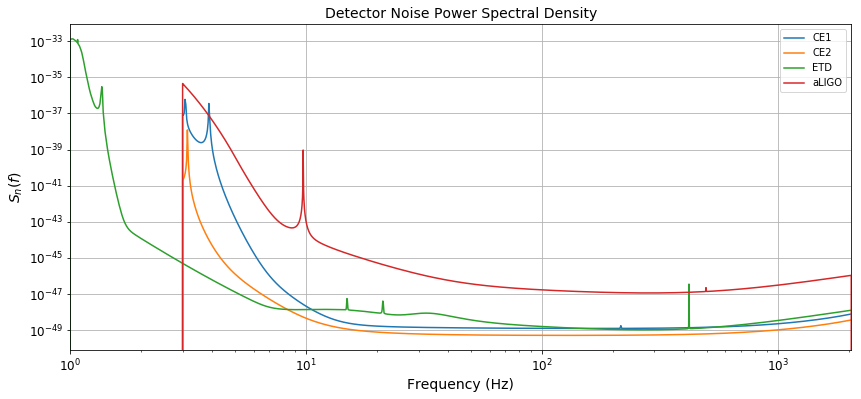

In [5]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.loglog(psd_ce1.sample_frequencies, psd_ce1, label = "CE1")
plt.plot(psd_ce2.sample_frequencies, psd_ce2, label = "CE2")
plt.plot(psd_etd.sample_frequencies, psd_etd, label = "ETD")
plt.plot(psd_aligo.sample_frequencies, psd_aligo, label = "aLIGO")
plt.legend()
plt.xlim([1,2048])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$S_n(f)$")
plt.title("Detector Noise Power Spectral Density")
plt.show()

### Generate a BNS waveform and compute its amplitude as a function of frequency

In [6]:
import pycbc.waveform

m1 = m2 = 1.4

sp_tilde, sc_tilde = pycbc.waveform.get_fd_waveform(approximant="TaylorF2", 
                                                    mass1=m1, mass2=m1, delta_f=delta_f, f_lower=f_low)
sp_tilde.resize(fd_length)
sp_sp_ast = np.absolute(sp_tilde.conj()*sp_tilde)

### Calculate the SNR integrand

The integrand of the matched filter SNR is given by $\frac{\tilde{h}(f)\tilde{h}^\ast(f)}{S_n(f)}$. Divide by zero errors can be ignored here. Not all of the values of $S_n(f)$ are populated, but we will slice these frequencies off later.

In [7]:
snr_integrand_ce1 = sp_sp_ast / psd_ce1
snr_integrand_ce2 = sp_sp_ast / psd_ce2
snr_integrand_etd = sp_sp_ast / psd_etd
snr_integrand_aligo = sp_sp_ast / psd_aligo

/usr/lib64/python2.7/site-packages/pycbc/types/array.py:368: RuntimeWarning: invalid value encountered in true_divide
  return self._data / other


### Plot the SNR integrand

#### Logarithmic frequency vs linear integrand

The correct way to visualize the SNR integrand is on a graph where both the abscissa and ordinate are plotted on a linear scale since the matched filter integrates with respect to $df$ and not $d\ln f$. However, this makes it hard to compare the value of the integrand at low frequencies, which is what we care about when investigating the computational cost. First we plot the integrand with the frequency on a logarithmic axis. CE1, CE2, and ETD have comparable sensitivites, so can be compares on a linear frequency axis. aLIGO is an two orders of magnitude less sensitive, that ETD so is not comparable to the other detectors on this plot.

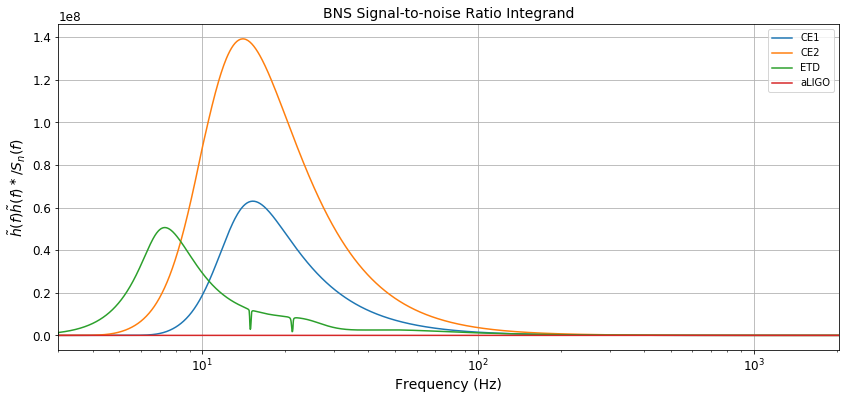

In [8]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.semilogx(snr_integrand_ce1.sample_frequencies, snr_integrand_ce1, label = "CE1")
plt.plot(snr_integrand_ce2.sample_frequencies, snr_integrand_ce2, label = "CE2")
plt.plot(snr_integrand_etd.sample_frequencies, snr_integrand_etd, label = "ETD")
plt.plot(snr_integrand_aligo.sample_frequencies, snr_integrand_aligo, label = "aLIGO")
plt.legend()
plt.xlim([3,2048])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f) \tilde{h}(f)^\ast / S_n(f)$")
plt.title("BNS Signal-to-noise Ratio Integrand")
plt.show()

We can immediately see from the above figure that the peak of the ETD sensitivity occurs at significantly lower frequencies than either of the Cosmic Explorer noise configurations, which is consistent with the noise curves shown above.

#### Logarithmic frequency vs logarithmic integrand

We now replot the data shown in the figure directly above on with logarithmic axes. This allows us to compare aLIGO to the third-generation detectors, but is more visually misleading when attempting to compare frequency contributions to the SNR.

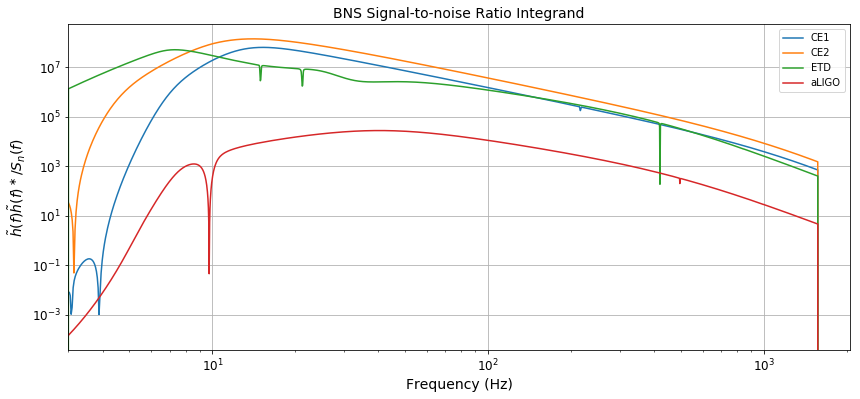

In [9]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.loglog(snr_integrand_ce1.sample_frequencies, snr_integrand_ce1, label = "CE1")
plt.plot(snr_integrand_ce2.sample_frequencies, snr_integrand_ce2, label = "CE2")
plt.plot(snr_integrand_etd.sample_frequencies, snr_integrand_etd, label = "ETD")
plt.plot(snr_integrand_aligo.sample_frequencies, snr_integrand_aligo, label = "aLIGO")
plt.legend()
plt.xlim([3,2048])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f) \tilde{h}(f)^\ast / S_n(f)$")
plt.title("BNS Signal-to-noise Ratio Integrand")
plt.show()

Notice that at just above 10 Hz (typically used as the low-frequency cutoff in aLIGO analyses), the contribution to the SNR has decreased by more than two orders of magnitude compares to the peak contribution at the most sensitive frequencies.

While both CE1 and CE2 are significantly more sensitive than aLIGO across the entire band and have their peak sensitivity at somewhat lower frequencies, it is the search bandwith that matters to the computational cost of searches. We can see from the above plot that the sensitivity of CE2 has dropped by two orders of magnitude around 7Hz, and for CE2 the sensitivity has dropped by two orders of magnitude around 4 Hz.

However, for ETD the peak sensitivity is less than 10 Hz and the sensitivity has not quite fallen off by two orders of magintude at 3 Hz.

This difference in noise curve shape will make a substantial difference to the computational cost for searches in Cosmic Explorer vs Einstein Telescope.

### Compute normalized SNR integrand

To get a quantitative comparison, we compute the normalized SNR integrand in each detector. This is equivalent to setting the SNR of the source to unity in each detector.

In [10]:
norm_ce1 = np.trapz(snr_integrand_ce1[int(f_low / snr_integrand_ce1.delta_f + 1):], 
                    snr_integrand_ce1.sample_frequencies[int(f_low / snr_integrand_ce1.delta_f + 1):])
norm_ce2 = np.trapz(snr_integrand_ce2[int(f_low / snr_integrand_ce2.delta_f + 1):], 
                    snr_integrand_ce2.sample_frequencies[int(f_low / snr_integrand_ce2.delta_f + 1):])
norm_etd = np.trapz(snr_integrand_etd[int(f_low / snr_integrand_etd.delta_f + 1):], 
                    snr_integrand_etd.sample_frequencies[int(f_low / snr_integrand_etd.delta_f + 1):])
norm_aligo = np.trapz(snr_integrand_aligo[int(f_low / snr_integrand_aligo.delta_f + 1):-1], 
                    snr_integrand_aligo.sample_frequencies[int(f_low / snr_integrand_aligo.delta_f + 1):-1])
gc.collect()
norm_snr_integrand_ce1 = snr_integrand_ce1/norm_ce1
norm_snr_integrand_ce2 = snr_integrand_ce2/norm_ce2
norm_snr_integrand_etd = snr_integrand_etd/norm_etd
norm_snr_integrand_aligo = snr_integrand_aligo/norm_aligo

### Plot normalized SNR integrand

To compare the detectors, we plot the normalized SNR on a linear scale. This gives us a visual representation of what the matched filter sees when it is integrating up the SNR. Since the abscissa is linear, we can integrate by eye as the bin width does not change with frequency.

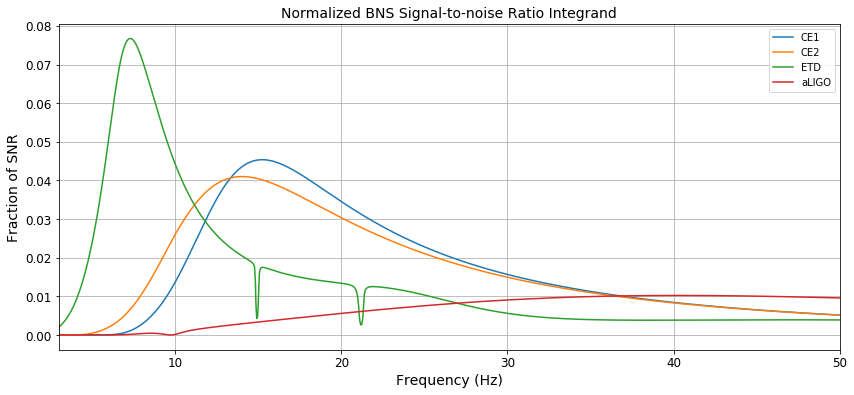

In [11]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(snr_integrand_ce1.sample_frequencies, norm_snr_integrand_ce1, label = "CE1")
plt.plot(snr_integrand_ce2.sample_frequencies, norm_snr_integrand_ce2, label = "CE2")
plt.plot(snr_integrand_etd.sample_frequencies, norm_snr_integrand_etd, label = "ETD")
plt.plot(snr_integrand_aligo.sample_frequencies, norm_snr_integrand_aligo, label = "aLIGO")
plt.legend()
plt.xlim([3,50])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Fraction of SNR")
plt.title("Normalized BNS Signal-to-noise Ratio Integrand")
gc.collect()
plt.show()

Now we can see the substantial difference between ET-D and Cosmic Explorer. The vast majority of the SNR for CE1 is coming from frequencies above 10 Hz. This is still true even for CE2. However, the majority of the SNR for ET-D comes from *below* 10 Hz. If the ET-D low-frequency sensitivity can be realized, this means that improved data-analysis techinques will be needed for Einstein Telescope. However, Cosmic Explorer looks much more similar to aLIGO

### SNR as a function of low-frequency cutoff

To quantify this, we compute the $\rho^2(f_\mathrm{low})$, that is the SNR obtained from integrating from the highest frequency to a low-frequency cutoff of $f_\mathrm{low}$.

In [12]:
cumulative_snr_ce1 = np.cumsum(np.flipud(norm_snr_integrand_ce1[int(f_low / snr_integrand_ce1.delta_f + 1):]))/(fd_length*delta_f)
cumulative_snr_ce2 = np.cumsum(np.flipud(norm_snr_integrand_ce2[int(f_low / snr_integrand_ce2.delta_f + 1):]))/(fd_length*delta_f)
cumulative_snr_etd = np.cumsum(np.flipud(norm_snr_integrand_etd[int(f_low / snr_integrand_etd.delta_f + 1):]))/(fd_length*delta_f)
cumulative_snr_aligo = np.cumsum(np.flipud(norm_snr_integrand_aligo[int(f_low / snr_integrand_aligo.delta_f + 1):-1]))/(fd_length*delta_f)

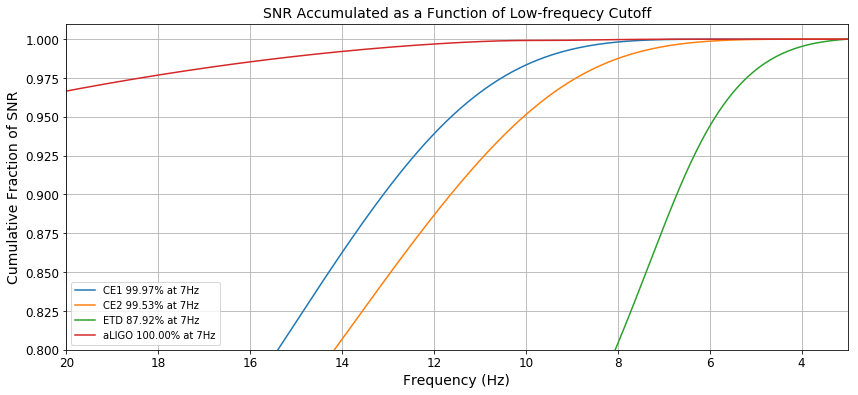

In [13]:
gc.collect()
fig = plt.figure()
fig.patch.set_facecolor('white')
f = np.flipud(snr_integrand_ce1.sample_frequencies[int(f_low / snr_integrand_ce1.delta_f + 1):])
seven_idx = np.where(f<7.0)[0][0]
plt.plot(f, cumulative_snr_ce1, label = "CE1 {snr_frac:.2f}% at 7Hz".format(snr_frac=cumulative_snr_ce1[seven_idx]*100.0))
f = np.flipud(snr_integrand_ce2.sample_frequencies[int(f_low / snr_integrand_ce2.delta_f + 1):])
seven_idx = np.where(f<7.0)[0][0]
plt.plot(f, cumulative_snr_ce2, label = "CE2 {snr_frac:.2f}% at 7Hz".format(snr_frac=cumulative_snr_ce2[seven_idx]*100.0))
f = np.flipud(snr_integrand_etd.sample_frequencies[int(f_low / snr_integrand_etd.delta_f + 1):])
seven_idx = np.where(f<7.0)[0][0]
plt.plot(f, cumulative_snr_etd, label = "ETD {snr_frac:.2f}% at 7Hz".format(snr_frac=cumulative_snr_etd[seven_idx]*100.0))
f = np.flipud(snr_integrand_etd.sample_frequencies[int(f_low / snr_integrand_etd.delta_f + 1):])
seven_idx = np.where(f<7.0)[0][0]
plt.plot(np.flipud(snr_integrand_aligo.sample_frequencies[int(f_low / snr_integrand_aligo.delta_f + 1):-1]), cumulative_snr_aligo, label = "aLIGO {snr_frac:.2f}% at 7Hz".format(snr_frac=cumulative_snr_aligo[seven_idx]*100.0))
plt.legend()
plt.xlim([20,3])
plt.ylim([0.80,1.01])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Cumulative Fraction of SNR")
plt.title("SNR Accumulated as a Function of Low-frequecy Cutoff")
gc.collect()
plt.show()

We can see from the above plot that both CE1 and CE2 have accumulated more than 99.9% of the total SNR from fequencies above 7 Hz. Compare this to ET-D, which has only accumulated 88% of the SNR at 7 Hz and needs to integrate to below 3.3 Hz to get more than 99.9% of the SNR.

For comparison a BNS signal that starts at 7 Hz has a length of 4600 seconds (77 minutes) whereas one that starts at 3.3 Hz has a length of 19000 seconds (5.3 hours).

## Template Bank Sizes

To measure the template bank sizes and compare to Advanced LIGO for CE1 and CE2, we run the PyCBC geometric bank placement code for a typical binary neutron star bank.

Template bank generation takes about one hour, so we parallelize the process by launching each bank generation job. We watch the stderr until it enters the computationally intensive part of the bank generation and then lanch the next bank generation job. Once all three template bank generation jobs are running, we wait for them to finish.

In [14]:
%reset -f
import subprocess

### Generate Advanced LIGO template bank starting at 10 Hz

In [15]:
cmd_line = "pycbc_geom_nonspinbank --pn-order twoPN --f0 10 --f-low 10 --f-upper 2048 --delta-f 0.01 " + \
    "--min-match 0.97 --min-mass1 1.0 --min-mass2 1.0 --max-mass1 3. --max-mass2 3. --verbose " + \
    "--output-file aligo_bank.xml --filter-cutoff SchwarzISCO --psd-model aLIGOaLIGODesignSensitivityT1800044"
cmd_args = ','.join('"{}"'.format(word) for word in cmd_line.split(' '))
bank_proc_aligo = subprocess.Popen(eval(cmd_args),stderr=subprocess.PIPE)


In [16]:
line = ""
while not "guide" in line:
    line = bank_proc_aligo.stderr.readline()
    print line,

/usr/lib64/python2.7/site-packages/cryptography/__init__.py:39: CryptographyDeprecationWarning: Python 2 is no longer supported by the Python core team. Support for it is now deprecated in cryptography, and will be removed in a future release.
  CryptographyDeprecationWarning,
2020-09-17 15:08:18,030 Obtaining PSD
2020-09-17 15:08:18,060 Calculating metric
2020-09-17 15:08:27,362 Calculating covariance matrix
2020-09-17 15:08:30,764 Estimating extent of parameter space
2020-09-17 15:09:28,058 Calculating lattice
2020-09-17 15:09:31,852 152834 points in the lattice
2020-09-17 15:09:42,088 Sorting guide points


### Generate CE1 template bank starting at 7 Hz

In [17]:
cmd_line = "pycbc_geom_nonspinbank --pn-order twoPN --f0 7 --f-low 7 --f-upper 2048 --delta-f 0.01 " + \
    "--min-match 0.97 --min-mass1 1.0 --min-mass2 1.0 --max-mass1 3. --max-mass2 3. --verbose " + \
    "--output-file ce1_40km_cb_bank.xml --filter-cutoff SchwarzISCO --asd-file noise-curves/ce1_40km_cb.txt"
cmd_args = ','.join('"{}"'.format(word) for word in cmd_line.split(' '))
bank_proc_ce1 = subprocess.Popen(eval(cmd_args),stderr=subprocess.PIPE)

In [18]:
line = ""
while not "guide" in line:
    line = bank_proc_ce1.stderr.readline()
    print line,

/usr/lib64/python2.7/site-packages/cryptography/__init__.py:39: CryptographyDeprecationWarning: Python 2 is no longer supported by the Python core team. Support for it is now deprecated in cryptography, and will be removed in a future release.
  CryptographyDeprecationWarning,
2020-09-17 15:09:48,080 Obtaining PSD
2020-09-17 15:09:48,162 Calculating metric
2020-09-17 15:10:00,575 Calculating covariance matrix
2020-09-17 15:10:06,723 Estimating extent of parameter space
2020-09-17 15:11:07,018 Calculating lattice
2020-09-17 15:11:09,509 327406 points in the lattice
2020-09-17 15:11:17,944 Sorting guide points


### Generate CE2 template bank starting at 7 Hz

In [19]:
cmd_line = "pycbc_geom_nonspinbank --pn-order twoPN --f0 7 --f-low 7 --f-upper 2048 --delta-f 0.01 " + \
    "--min-match 0.97 --min-mass1 1.0 --min-mass2 1.0 --max-mass1 3. --max-mass2 3. --verbose " + \
    "--output-file ce2_40km_cb_bank.xml --filter-cutoff SchwarzISCO --asd-file noise-curves/ce2_40km_cb.txt"
cmd_args = ','.join('"{}"'.format(word) for word in cmd_line.split(' '))
bank_proc_ce2 = subprocess.Popen(eval(cmd_args),stderr=subprocess.PIPE)

In [20]:
line = ""
while not "guide" in line:
    line = bank_proc_ce2.stderr.readline()
    print line,

/usr/lib64/python2.7/site-packages/cryptography/__init__.py:39: CryptographyDeprecationWarning: Python 2 is no longer supported by the Python core team. Support for it is now deprecated in cryptography, and will be removed in a future release.
  CryptographyDeprecationWarning,
2020-09-17 15:11:27,352 Obtaining PSD
2020-09-17 15:11:27,421 Calculating metric
2020-09-17 15:11:34,519 Calculating covariance matrix
2020-09-17 15:11:38,038 Estimating extent of parameter space
2020-09-17 15:12:22,279 Calculating lattice
2020-09-17 15:12:24,173 469431 points in the lattice
2020-09-17 15:12:34,257 Sorting guide points


### Wait for the generation to finish

In [21]:
ret = bank_proc_aligo.wait()
if ret == 0:
    print "aLIGO bank generation complete"
else:
    print "aLIGO bank generation failed with error code {}".format(ret)

aLIGO bank generation complete


In [22]:
ret = bank_proc_ce1.wait()
if ret == 0:
    print "CE1 bank generation complete"
else:
    print "CE1 bank generation failed with error code {}".format(ret)

CE1 bank generation complete


In [23]:
ret = bank_proc_ce2.wait()
if ret == 0:
    print "CE2 bank generation complete"
else:
    print "CE2 bank generation failed with error code {}".format(ret)

CE2 bank generation complete


### Template bank comparison

We print the template bank sizes from the aLIGO, CE1, and CE2 banks.

In [24]:
!ligolw_print -t sngl_inspiral -c mass1 aligo_bank.xml | wc -l

66016


In [26]:
!ligolw_print -t sngl_inspiral -c mass1 ce1_40km_cb_bank.xml | wc -l

156567


In [27]:
!ligolw_print -t sngl_inspiral -c mass1 ce2_40km_cb_bank.xml | wc -l

214720


The CE1 and CE2 template banks are not substanially larger than the aLIGO banks.

The CE1 bank is only a factor of 2.4 larger than the aLIGO bank, and the CE2 bank is only a factor of 3.3 larger than the aLIGO bank.

Neither of these are a significant increase over the computational cost of Advanced LIGO, especially with another decade of advanced in hardware.